In [27]:
from keras import layers, models

모델링 클래스

input - hidden - output구조의 3개 layer 구조이다.

In [39]:
class AE(models.Model):
    def __init__(self, x_nodes=784, z_dim=36):        
        x = layers.Input(shape=(x_nodes,))
        z = layers.Dense(units=z_dim, activation='relu')(x)
        y = layers.Dense(units=x_nodes, activation='sigmoid')(z)
        
        # def __init__(self, inputs, outputs, name=None):
        super().__init__(inputs=x, outputs=y) #이걸 호출해줘야 아래 compile()에서 에러 안남(self.outputs가 설정이 된다.)
        
        self.x = x
        self.z = z
        self.z_dim = z_dim
        
        '''
        TODO : 'mse'로 하면 training속도는 빠른데 복원된 이미지가 더 나쁘다 왜 그런지?
        '''
        self.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
        
    def enc(self):
        return models.Model(self.x, self.z)
    
    def dec(self):
        z = layers.Input(shape=(self.z_dim, ))
        y_layer = self.layers[-1] #마지막 layer
        y = y_layer(z)
        return models.Model(z, y)

MNIST 데이터를 준비.
label은 필요 없으므로 버리고, fc로 사용할 것이므로 (-1, 28, 28)을 (-1, 784)로 편다.

In [40]:
from keras.datasets import mnist
import numpy as np

(X_train, _), (X_test, _) = mnist.load_data() #label은 필요 없으므로 별도 변수를 할당하지 않는다.

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

print(X_train.shape)
print(X_test.shape)

print(np.prod(X_train.shape[1:]))
# 아래 코드는 np.prod(...)대신에 -1을 넣어도 동일하다.
# np.prod()는 넘겨받은 배열의 element들을 다 곱한 값을 돌려준다.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)
784
(60000, 784)
(10000, 784)


학습 효과 분석

In [41]:
from utils.skeras import plot_loss, plot_acc
import matplotlib.pyplot as plt

# AE 동작 확인
def show_ae(ae):
    enc = ae.enc()
    dec = ae.dec()
    
    # X_test 이미지를 encoder 통과시켜서 인코딩 한다.
    encoded_imgs = enc.predict(X_test)
    '''
    784 -> 36으로 줄어들어 있다.
    '''
    print("encoded_imgs.shape : ", encoded_imgs.shape) # (10000, 36)
    decoded_imgs = dec.predict(encoded_imgs) # decoder가 복원하게 한다.
    
    n = 10
    plt.figure(figsize=(20,6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1) #nrows, ncols, index
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.plot(encoded_imgs[i].reshape(-1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        
    plt.show()
    


학습

In [42]:
def main():
    x_nodes = 784
    z_dim = 36
    
    autoencoder = AE(x_nodes, z_dim)
    '''
    autoencoder에서 training에서는 encoder-decoder 전체 네트워크를 사용한다.
    입/출력 모두 X_train을 넣으므로 autoencoder로 encoding후 decoding된 이미지와 원본간 차이가 loss가 된다.
    '''
    history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=256, shuffle=True, validation_data=(X_test, X_test))
    
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()

    show_ae(autoencoder)
    plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 55us/step - loss: 0.1209 - acc: 0.0060 - val_loss: 0.0719 - val_acc: 0.0111
Epoch 2/10
60000/60000 [==============================] - 3s 44us/step - loss: 0.0703 - acc: 0.0109 - val_loss: 0.0692 - val_acc: 0.0111
Epoch 3/10
60000/60000 [==============================] - 3s 44us/step - loss: 0.0681 - acc: 0.0116 - val_loss: 0.0670 - val_acc: 0.0120
Epoch 4/10
60000/60000 [==============================] - 3s 44us/step - loss: 0.0655 - acc: 0.0113 - val_loss: 0.0637 - val_acc: 0.0126
Epoch 5/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0620 - acc: 0.0112 - val_loss: 0.0597 - val_acc: 0.0133
Epoch 6/10
60000/60000 [==============================] - 3s 45us/step - loss: 0.0580 - acc: 0.0119 - val_loss: 0.0557 - val_acc: 0.0146
Epoch 7/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.0544 - acc: 0.0119 - val_loss: 0.0524 - val_acc

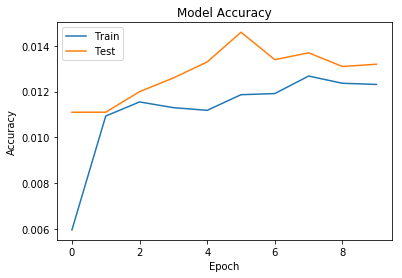

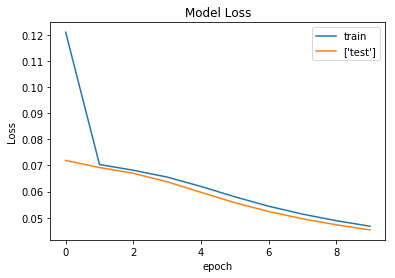

encoded_imgs.shape :  (10000, 36)


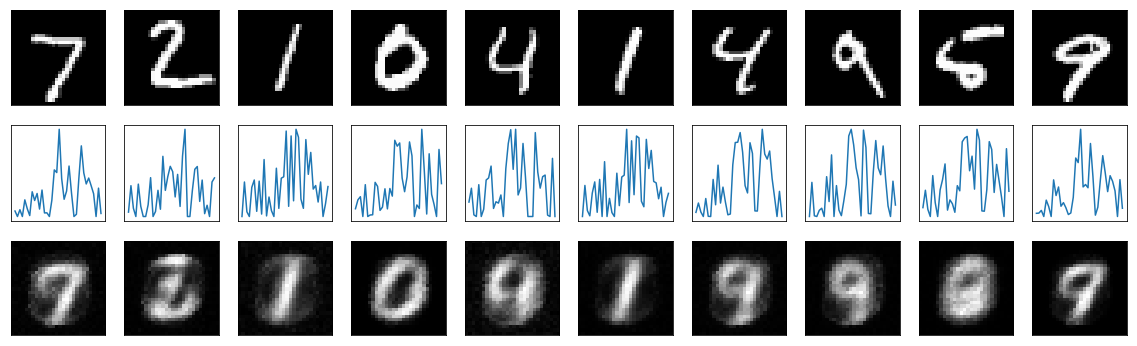

In [43]:
if __name__ == '__main__':
    main()